<a href="https://colab.research.google.com/github/BMClab/datasets/blob/master/BMC_RIC/notebooks/BMC_RIC_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interlaboratory study towards combining gait kinematics datasets of long-distance runners

> Reginaldo K Fukuchi, Marcos Duarte and Reed Ferber

This dataset is located on figshare, however it is not easy to run this notebook in the cloud and load the data from figshare repository (although there is a figshare API).  

To make it possible to run this notebook in the cloud, the data will be loaded from a copy in the GitHub repository (the dataset is small enough to be stored on GitHub).

## Setup

In [1]:
#@title ### import libraries {display-mode: "form"}

import sys, os, glob, datetime
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
# import/install less common libraries
try:
    import pingouin as pg
except:
    !pip install -q pingouin
    import pingouin as pg
try:
    import spm1d
except:
    !pip install -q spm1d
    import spm1d

try:
    import power1d
except:
    !pip install -q spm1d
    import power1d

try:
    %matplotlib widget
except:
    !pip install -q ipympl
    %matplotlib widget

if os.getenv("COLAB_RELEASE_TAG"):
    from google.colab import output
    output.enable_custom_widget_manager()

import warnings
warnings.filterwarnings("ignore")

print(f'Python {sys.version} on {sys.platform}', f' numpy {np.__version__}',
      f' pandas {pd.__version__}', f' pingouin {pg.__version__}', f' spm1d {spm1d.__version__}',
      datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"), sep='\n')

Python 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:40:50) [MSC v.1937 64 bit (AMD64)] on win32
 numpy 1.26.0
 pandas 2.0.3
 pingouin 0.5.4
 spm1d 0.4.22 (2023-10-24)
22/04/2024 00:23:36


### Configuration

In [2]:
#@title #### Plot style {display-mode: "form"}
sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 1})
sns.set_style('whitegrid')
colors = sns.color_palette()
display(colors)
pd.set_option('display.precision', 3)

import warnings
warnings.filterwarnings("ignore")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

### Dataset location

In [3]:
#@title #### Path {display-mode: "form"}
# LOCAL
path2 = Path('../data')
os_sep = os.sep
metadata_fname = 'metadata.txt'
if not os.path.isfile(path2 / metadata_fname):
    path2 = Path('data')
    if not os.path.isfile(path2 / metadata_fname):
        path2 = Path('.')
        if not os.path.isfile(path2 / metadata_fname):
            print('Dataset not found locally. It will be loaded from the GitHub repo.')
            # REMOTE
            path2 = 'https://raw.githubusercontent.com/BMClab/datasets/master/BMC_RIC/data'
            os_sep = '/'

path2 = str(path2)
print(f'Dataset location: {path2}')

Dataset location: ..\data


## Helping functions

In [4]:
#@title #### Functions {display-mode: "form"}

def ttest(df, var, factor, levels=None, alpha=0.05):
    """t-test statistcs for dataframe columns using the pingouin library.
    """
    stats = pd.DataFrame()
    if levels is None:
        levels = df[factor].unique()
    if len(levels) != 2:
        raise Exception('Incorrect number of levels: {}'.format(len(levels)))
    for v in var:
        x = df[df[factor] == levels[0]][v]
        y = df[df[factor] == levels[1]][v]
        stat = pg.ttest(x, y)
        stat.index = [v]
        stats0 = pd.concat([stats, stat], axis=0)
    stats0.drop(columns=['BF10', 'power'], inplace=True)
    stats0.index.name = '{}-{}'.format(*levels)
    display(stats0.style.format({'T': '{:.3f}', 'p-val': '{:.3f}', 'cohen-d': '{:.3f}'}
                              ).apply(sig_red, subset='p-val', axis=1))
    return stats

def normality(df):
    """Get the p-val of the normality test using the pingouin library.
    """
    return pg.normality(df)['pval']

def sig_red(col, alpha=0.05):
    """Returns string 'color: red' for `col` < `alpha`, black otherwise.
    """
    is_sig = col < alpha
    return ['color: red' if x else 'color: None' for x in is_sig]

def describe(df, by, var=['count', 'mean', 'std', 'min', 'max', normality]):
    """Descriptive statistics for dataframe columns.
    """
    x = df.groupby(by).agg(var).stack().transpose()
    display(x.style.apply(sig_red,
                          subset=[col for col in x.columns if col[1] == 'normality'])
                   .format(lambda y: f'{y:.0f}' if int(y)==y else f'{y:.3f}'))
    return x

## Load metadata

In [5]:
#@title #### Metadata {display-mode: "form"}
metadata = pd.read_csv(f'{path2}{os_sep}{metadata_fname}', sep='\t', index_col=0)
labs = metadata['Group'].unique().tolist()
display(metadata)

,Group,Subject,Trial,Filename,Speed,Age,Height,Mass
0,BMC,1,1,g01s01t01.txt,2.500,22.0,181.0,62.0
1,BMC,1,2,g01s01t02.txt,2.500,22.0,181.0,62.0
2,BMC,1,3,g01s01t03.txt,2.500,22.0,181.0,62.0
3,BMC,1,4,g01s01t04.txt,2.500,22.0,181.0,62.0
4,BMC,1,5,g01s01t05.txt,2.500,22.0,181.0,62.0
...,...,...,...,...,...,...,...,...
1609,RIC,23,66,g02s23t66.txt,2.467,29.0,181.0,68.7
1610,RIC,23,67,g02s23t67.txt,2.467,29.0,181.0,68.7
1611,RIC,23,68,g02s23t68.txt,2.467,29.0,181.0,68.7
1612,RIC,23,69,g02s23t69.txt,2.467,29.0,181.0,68.7


### Statistics for Age, Height and Mass per Group

In [6]:
#@title #### Tables with results {display-mode: "form"}
meta_s = metadata.drop_duplicates(subset=['Group', 'Subject']).reset_index(drop=True).drop(columns=['Filename', 'Trial'])
cols = ['Group', 'Age', 'Height', 'Mass', 'Speed']
table = meta_s[cols].groupby('Group').describe().stack().transpose()
display(table.style.format('{:.2f}'))

cols = ['Group', 'Age', 'Height', 'Mass', 'Speed']
describe(meta_s[cols], 'Group', var=['count', 'median', 'min', 'max', 'mean', 'std', normality]);

stats = ttest(meta_s, cols[2:], 'Group', levels=['BMC', 'RIC'])

,T,dof,alternative,p-val,CI95%,cohen-d
BMC-RIC,,,,,,
Speed,1.356,44,two-sided,0.182,[-0. 0.02],0.400


## Ensemble time-series

In [7]:
#@title #### Coordinate system conventions {display-mode: "form"}
joints  = ['Hip', 'Knee', 'Ankle']
axes    = ['Z', 'X', 'Y']
planes  = ['Sagittal', 'Frontal', 'Transverse']
angles  = [f'{joint}_{axis}' for joint in joints for axis in axes]
angles2 = [f'{joint} {plane}' for joint in joints for plane in planes]
print(f'Joints: {joints}')
print('Planes (axes):', [f'{plane} ({axis})' for plane, axis in zip(planes, axes)])
print(f'Columns in data: {angles}')
# angle convention
pos_angs = [['EXT', 'ABD', 'ER'], ['FLX', 'ABD', 'ER'], ['PF', 'EVE', 'ABD']]
neg_angs = [['FLX', 'ADD', 'IR'], ['EXT', 'ADD', 'IR'], ['DF', 'INV', 'ADD']]

Joints: ['Hip', 'Knee', 'Ankle']
Planes (axes): ['Sagittal (Z)', 'Frontal (X)', 'Transverse (Y)']
Columns in data: ['Hip_Z', 'Hip_X', 'Hip_Y', 'Knee_Z', 'Knee_X', 'Knee_Y', 'Ankle_Z', 'Ankle_X', 'Ankle_Y']


In [8]:
#@title #### Load and process all trials {display-mode: "form"}

groups = metadata['Group'].unique()
nsubjects = metadata[metadata['Group']==groups[0]]['Subject'].unique().size
ang_all = np.full([101, len(joints)*len(axes), nsubjects, len(groups)], np.nan)
ang_m   = np.full([101, len(joints)*len(axes), len(labs)], np.nan)
ang_sd  = np.full([101, len(joints)*len(axes), len(labs)], np.nan)

if 'https://' in path2:
    # data in the cloud, load dataset file with all data
    dfall = pd.read_csv(f'{path2}{os_sep}BMC_RIC_dataset.txt', sep='\t')
    cols = ['Group', 'Subject', 'Trial', 'Filename']
    dfall[cols] = dfall[cols].astype('category')
    display(dfall)
    #cols = ['Group', 'Subject', 'Time']
    #cols.extend(angles)
    #x = dfall[cols].groupby(['Group', 'Subject', 'Time']).agg(np.nanmedian)
    ## Mean and std across subjects
    #ang_m = np.moveaxis(x.groupby(['Group', 'Time']).mean().values.reshape(2, 101, 9), 0, 2)
    #ang_sd = np.moveaxis(x.groupby(['Group', 'Time']).std().values.reshape(2, 101, 9), 0, 2)
    for g, group in enumerate(tqdm(groups, desc='Group')):
        subjects = metadata[metadata['Group']==group]['Subject'].unique()
        for s, subject in enumerate(tqdm(subjects, desc='Subject')):
            yts = dfall[(dfall['Group']==group) & (dfall['Subject']==subject)].values[:, len(cols)+1:].reshape(-1, 101, 9).astype('float64')
            ang_all[:, :, s, g] = np.nanmedian(yts, axis=0)
else:
    for g, group in enumerate(tqdm(groups, desc='Group')):
        subjects = metadata[metadata['Group']==group]['Subject'].unique()
        for s, subject in enumerate(tqdm(subjects, desc='Subject')):
            trials = metadata[(metadata['Group']==group) & (metadata['Subject']==subject)]['Trial']
            yts = np.full([101, 9, len(trials)], np.nan)
            for t, trial in enumerate(trials):
                fname2 = f'g{g+1:02d}s{subject:02d}t{trial:02d}.txt'
                try:
                    yts[:, :, t] = np.loadtxt(f'{path2}{os_sep}{fname2}', skiprows=1, usecols=tuple(range(1, 10)))
                except:
                    print(f'File {fname2} not loaded.')
            ang_all[:, :, s, g] = np.nanmedian(yts, axis=2)

# Mean and std across subjects
ang_m  = np.nanmean(ang_all, axis=2)
ang_sd = np.nanstd(ang_all, axis=2, ddof=1)

Group:   0%|          | 0/2 [00:00<?, ?it/s]

Subject:   0%|          | 0/23 [00:00<?, ?it/s]

Subject:   0%|          | 0/23 [00:00<?, ?it/s]

## Statistical Power Analysis

In [9]:
from scipy import interpolate, stats

In [21]:
def plot_dataset(signal, baseline, noise, null, alt, ymin, ymax):
    "Plot the model and noise inputs required for power analysis"
    labels = ['signal', 'baseline', 'noise', 'null model', 'alternative', 'null + alt']

    fig, AX = plt.subplots(2, 3, figsize=(10, 6))
    ax0      = plt.subplot(231)
    ax1      = plt.subplot(232)
    ax2      = plt.subplot(233)
    ax3      = plt.subplot(234)
    ax4      = plt.subplot(235)
    ax5      = plt.subplot(236) 
    AX       = [ax0, ax1, ax2, ax3, ax4, ax5]
    
    signal.plot(ax=ax0, color='g')
    baseline.plot(ax=ax1, color='y')
    noise.plot(ax=ax2)    
    null.plot(ax=ax3)
    alt.plot(ax=ax4, color='m')
    null.plot(ax=ax5)
    alt.plot(ax=ax5, color='m')
    
    for ax,s in zip( AX , labels ):
            ax.text(0.05, 0.9, s, transform=ax.transAxes, bbox=dict(facecolor='w'))
            ax.set_ylim([ymin, ymax])
            
    ax2.set_ylim([-7,7])
    
    plt.tight_layout()
    plt.show()

def power_analysis(null, alt):
    "Power calculation - input models.DataSameple objects with plot"
    # create experiment models:
    teststat = power1d.stats.t_1sample
    emodel0  = power1d.models.Experiment( null , teststat )    # null hypothesis
    emodel1  = power1d.models.Experiment( alt , teststat )    # alternative hypothesis   

    # simulate the experiments:
    sim      = power1d.ExperimentSimulator( emodel0 , emodel1 )
    results  = sim.simulate( 5000, progress_bar=True )

    # visualize the power results:
    plt.figure(figsize=(10, 6))
    results.plot()     
    plt.show()
    
    return emodel0, emodel1
        
def sample_size_calc(model0, model1, emodel0, emodel1, q):
    "Simulate sample size calculation with plot"
    
    np.random.seed(0)    #seed the random number generator
    JJ         = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]  #sample sizes
    tstat      = power1d.stats.t_1sample  #test statistic function
    emodel0    = power1d.models.Experiment(model0, tstat) # null
    emodel1    = power1d.models.Experiment(model1, tstat) # alternative
    sim        = power1d.ExperimentSimulator(emodel0, emodel1)
    
    ### loop through the different sample sizes:
    power_omni = []
    power_coi  = []
    coir       = 3
    for J in JJ:
            emodel0.set_sample_size( J )
            emodel1.set_sample_size( J )
            results = sim.simulate( 5000 )
            results.set_coi( ( q , coir ) )  #create a COI at the signal location
            power_omni.append( results.p_reject1 )  #omnibus power
            power_coi.append( results.p_coi1[0] )   #coi power
    
    #(3) Plot the results:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(JJ, power_omni, 'o-', label='Omnibus')
    ax.plot(JJ, power_coi,  'o-', label='COI (radius=%d)' %coir)
    ax.axhline(0.8, color='k', linestyle='--')
    ax.set_xlabel('Sample size', size=14)
    ax.set_ylim([0,1])
    ax.set_ylabel('Power', size=14)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    return power_omni, power_coi


def effect_size(model1,baseline,noise):
    "1D effect size based on power1d models"
    es = ( model1.value0 - baseline.toarray() ) / noise.sigma
    #plt.plot(es)
    return(es)

def power_1sample(n, effect, alpha=0.05):
	delta  = effect * n ** 0.5   # non-centrality parameter
	u      = stats.t.isf( alpha , n-1 )
	return stats.nct.sf( u , n-1 , delta )

def sample_size_1sample(effect, alpha=0.05, target_power=0.8, n_range=(3,50)):
	'''
	Adjust n_range to a broader sample size range if necessary
	'''
	n   = np.arange( *n_range )
	p   = np.array([power_1sample(nn, effect, alpha) for nn in n])
	ind = np.argwhere(p > target_power).flatten()[0]
	return n[ind]

In [11]:
# Effect Datasets
J  = 8
Q  = 101
JJ = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

## Hip Frontal Plane Angle

In [12]:
# Average SD of the moment Y DK signal was 0.5
data4sd =  np.std(ang_all[:, 1, :, 0], axis=1).mean() # mean SD across 101 points

data4_bl = power1d.geom.Continuum1D( ang_all[:, 1, :, 0].mean(axis=1) ) # baseline
data4_sig0  = power1d.geom.Null( Q ) # null signal - needed for null power model
data4_sig1 = power1d.geom.Continuum1D( ang_all[:, 1, :, 1].mean(axis=1) ) # alternative signal
data4_nse    = power1d.noise.SmoothGaussian( J , Q , mu = 0 , sigma = data4sd , fwhm = 20 )

data4_mod0   = power1d.models.DataSample( data4_bl, data4_sig0, data4_nse, J ) # null for power analysis
data4_mod1   = power1d.models.DataSample( data4_bl, data4_sig1, data4_nse, J ) # alternative

data4_es = effect_size(data4_mod1, data4_bl, data4_nse) # 1D effect size
data4_ss_0d = sample_size_1sample(data4_es[0],alpha=0.05, target_power=0.8, n_range=(3,50)) # 0D sample size

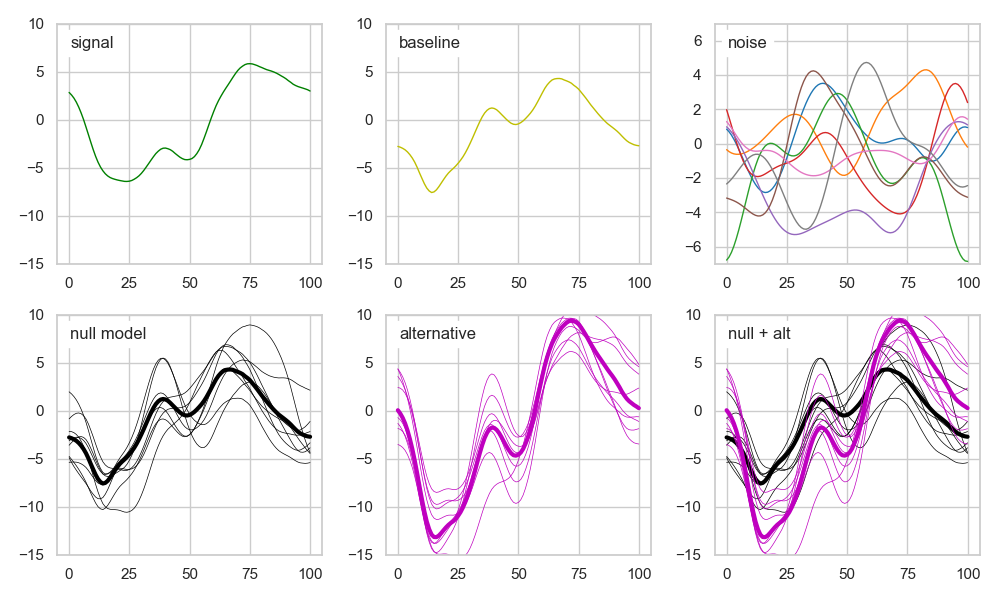

In [17]:
plot_dataset(data4_sig1, data4_bl, data4_nse, data4_mod0, data4_mod1, -15, 10)

[Simulating                                        ........................................



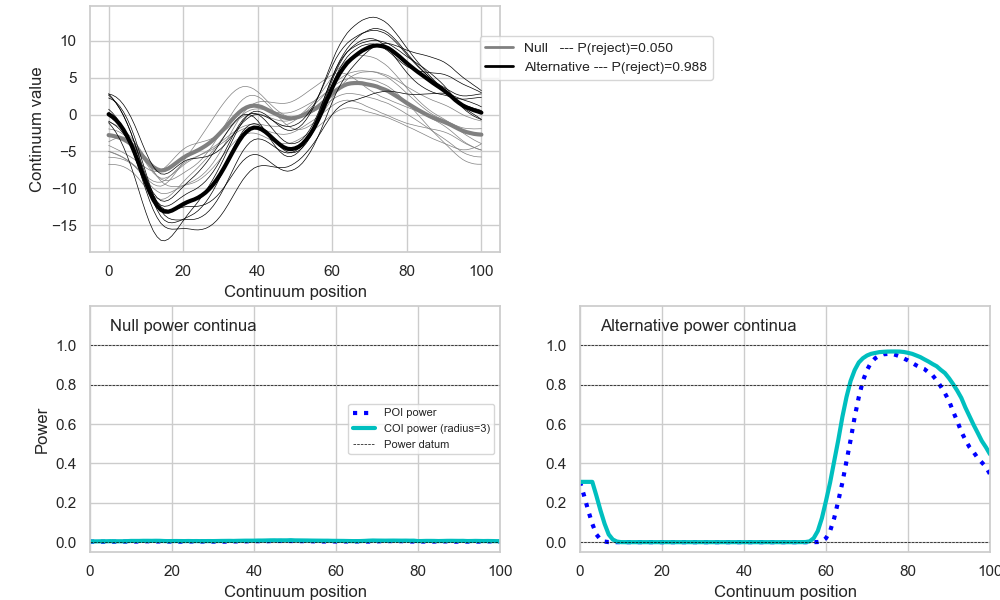

In [20]:
(data4_emod0, data4_emod1) = power_analysis(data4_mod0, data4_mod1)

In [22]:
# Find index of max data4_es
ind_es_max = np.argmax(np.abs(data4_es))

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................



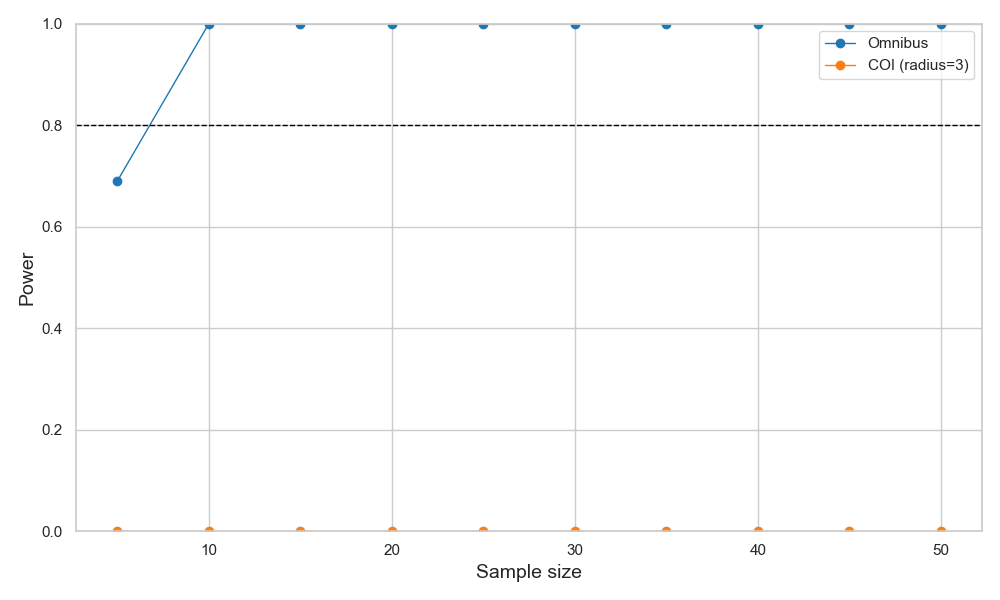

In [23]:
(data4_pwr_omni, data4_pwr_coi) = sample_size_calc(data4_mod0, data4_mod1, data4_emod0, data4_emod1, int(ind_es_max)) # What should q be for this effect?

## Hip Transverse Plane Angle

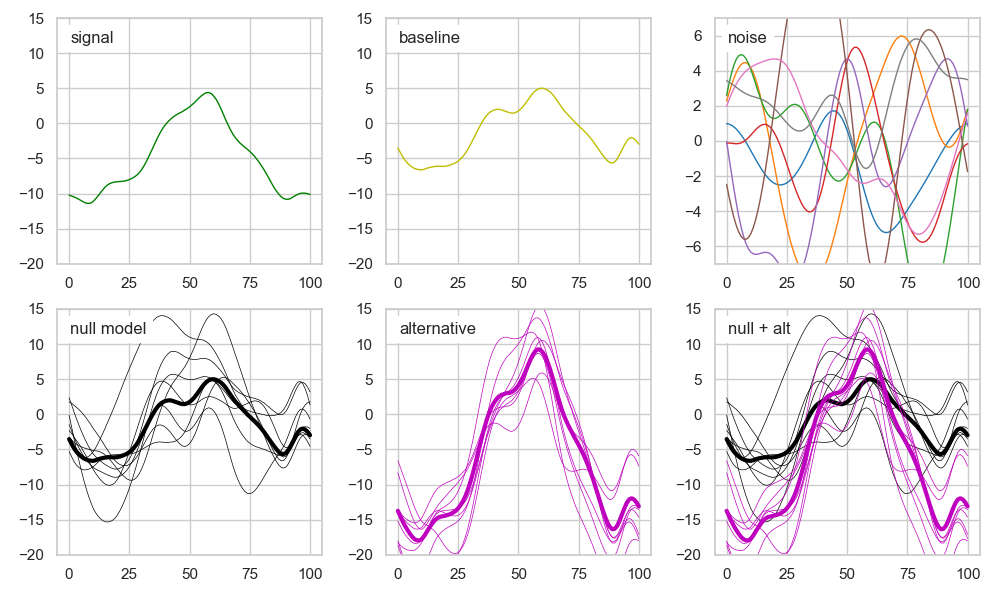

In [27]:
# Average SD of the moment Y DK signal was 0.5
data4sd =  np.std(ang_all[:, 2, :, 0], axis=1).mean() # mean SD across 101 points

data4_bl = power1d.geom.Continuum1D( ang_all[:, 2, :, 0].mean(axis=1) ) # baseline
data4_sig0  = power1d.geom.Null( Q ) # null signal - needed for null power model
data4_sig1 = power1d.geom.Continuum1D( ang_all[:, 2, :, 1].mean(axis=1) ) # alternative signal
data4_nse    = power1d.noise.SmoothGaussian( J , Q , mu = 0 , sigma = data4sd , fwhm = 20 )

data4_mod0   = power1d.models.DataSample( data4_bl, data4_sig0, data4_nse, J ) # null for power analysis
data4_mod1   = power1d.models.DataSample( data4_bl, data4_sig1, data4_nse, J ) # alternative

data4_es = effect_size(data4_mod1, data4_bl, data4_nse) # 1D effect size
plot_dataset(data4_sig1, data4_bl, data4_nse, data4_mod0, data4_mod1, -20, 15)

[Simulating                                        ........................................



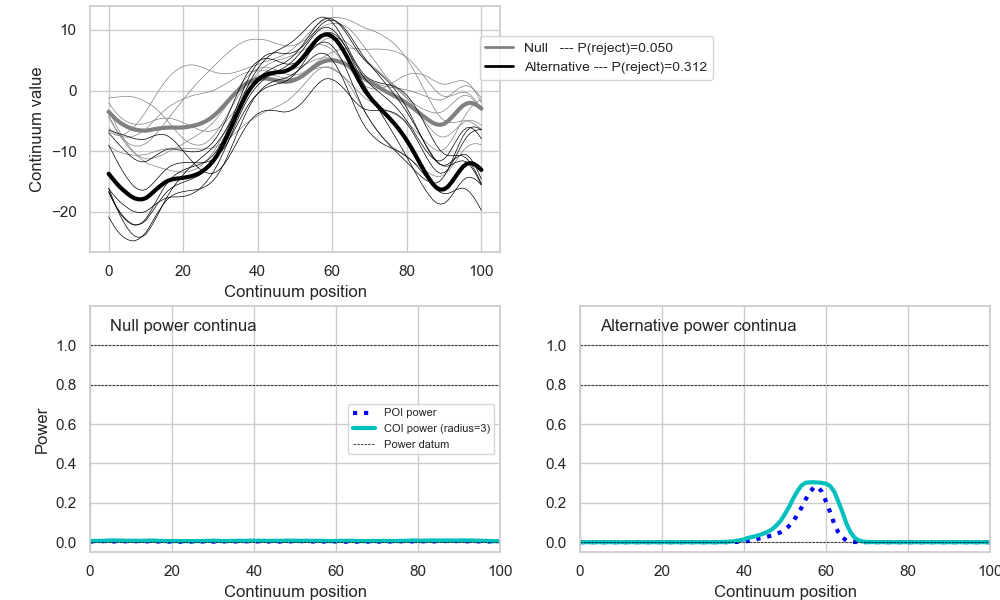

In [28]:
(data4_emod0, data4_emod1) = power_analysis(data4_mod0, data4_mod1)

In [29]:
# Find index of max data4_es
ind_es_max = np.argmax(np.abs(data4_es))

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................



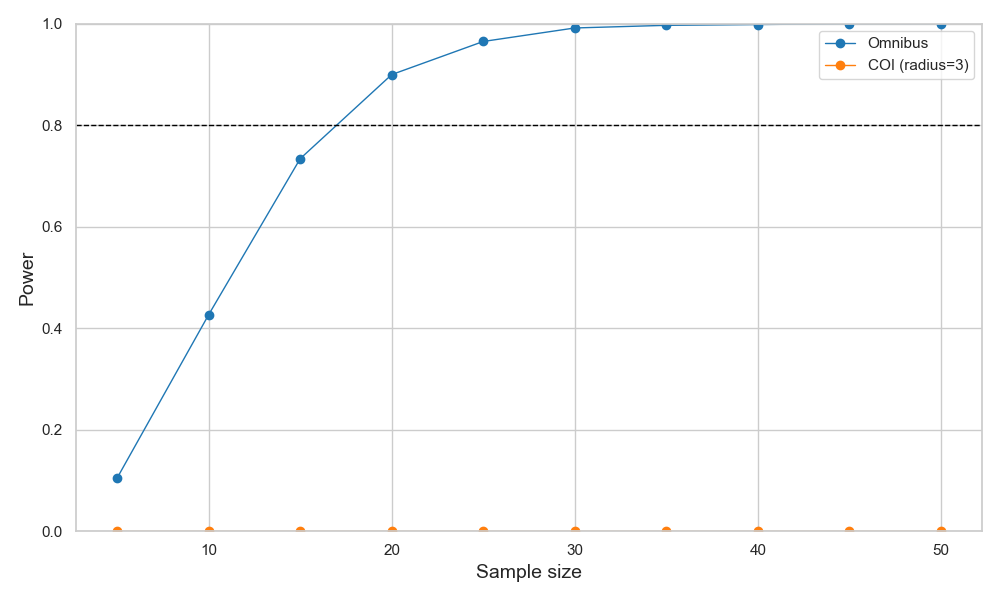

In [30]:
(data4_pwr_omni, data4_pwr_coi) = sample_size_calc(data4_mod0, data4_mod1, data4_emod0, data4_emod1, int(ind_es_max)) # What should q be for this effect?

## Knee Transverse Plane Angle

In [40]:
avg_diff = np.mean(ang_all[:, 5, :, 1].mean(axis=1)-ang_all[:, 5, :, 0].mean(axis=1))

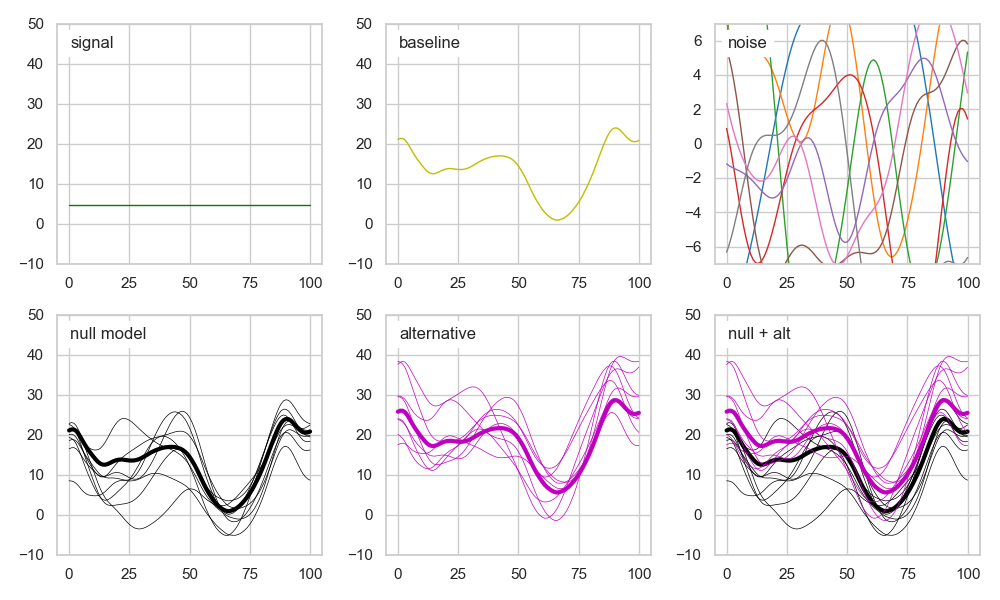

In [41]:
# Average SD of the moment Y DK signal was 0.5
data4sd =  np.std(ang_all[:, 5, :, 0], axis=1).mean() # mean SD across 101 points

data4_bl = power1d.geom.Continuum1D( ang_all[:, 5, :, 0].mean(axis=1) ) # baseline
data4_sig0  = power1d.geom.Null( Q ) # null signal - needed for null power model
data4_sig1  = power1d.geom.Constant( Q , amp= avg_diff ) #signal
data4_nse    = power1d.noise.SmoothGaussian( J , Q , mu = 0 , sigma = data4sd , fwhm = 20 )

data4_mod0   = power1d.models.DataSample( data4_bl, data4_sig0, data4_nse, J ) # null for power analysis
data4_mod1   = power1d.models.DataSample( data4_bl, data4_sig1, data4_nse, J ) # alternative

data4_es = effect_size(data4_mod1, data4_bl, data4_nse) # 1D effect size
plot_dataset(data4_sig1, data4_bl, data4_nse, data4_mod0, data4_mod1, -10, 50)

[Simulating                                        ........................................



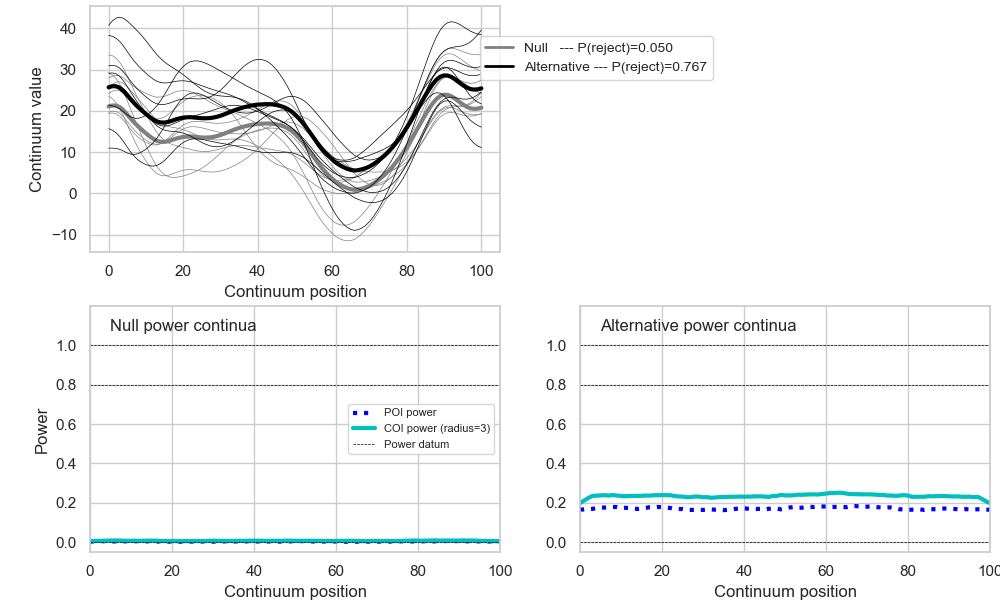

In [42]:
(data4_emod0, data4_emod1) = power_analysis(data4_mod0, data4_mod1)

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................

[Simulating                                        ........................................



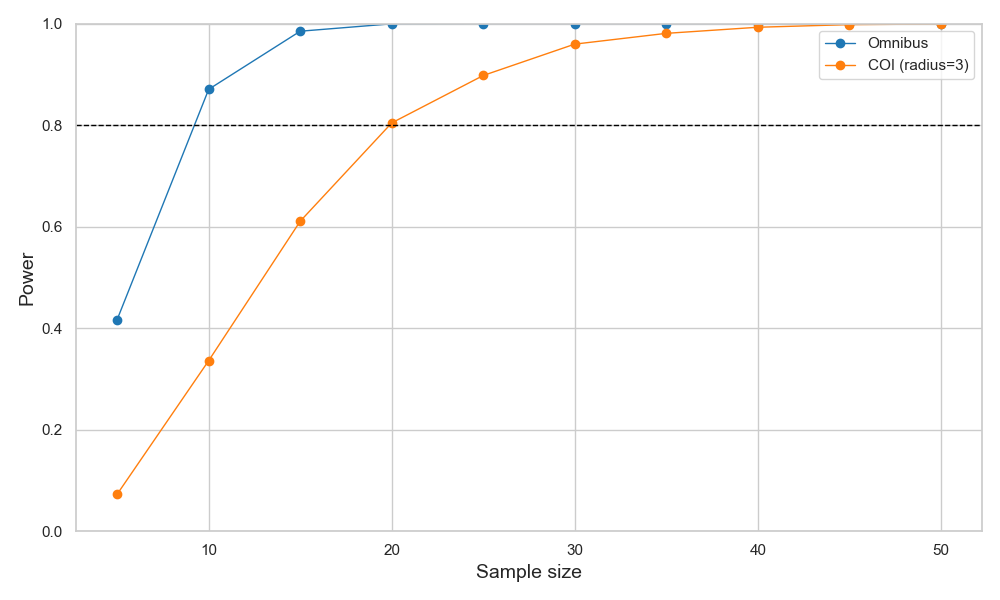

In [47]:
(data4_pwr_omni, data4_pwr_coi) = sample_size_calc(data4_mod0, data4_mod1, data4_emod0, data4_emod1, 50) # What should q be for constant effect?